In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [ ]:
!pip install efficientnet_pytorch
# !git clone https://github.com/lukemelas/EfficientNet-PyTorch
# !pip install -e .

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b41be455dc29835a79b5b15c7bf7347c60971f79069036bef06272cc5a9b4db5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
# !git clone https://github.com/lukemelas/EfficientNet-PyTorch
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn # 신경망 구성
import torch.optim as optim # 최적화 알고리즘
from torch.optim import lr_scheduler # 학습률 조정
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import time
import os
import copy
import random

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained("efficientnet-b0")
model_name = "efficientnet-b0"

model._fc = nn.Linear(1280, 46)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 17.2MB/s]

Loaded pretrained weights for efficientnet-b0
1280


In [1]:
#batch_size = 128
batch_size = 256
random.seed(42)
torch.manual_seed(42)

print(os.getcwd())
data_path= "/content/drive/MyDrive/car_label"
# data_path= "C:/final_project/efficientnet/car_label"

car_dataset = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]))

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_idx,tmp_idx = train_test_split(list(range(len(car_dataset))), test_size=0.2, random_state=42)
datasets = {}
datasets["train"] = Subset(car_dataset,train_idx)
tmp_dataset = Subset(car_dataset,tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=42)

datasets["valid"] = Subset(tmp_dataset,val_idx)
datasets["test"] = Subset(tmp_dataset,test_idx)

dataloaders,batch_num = {}, {}

dataloaders["train"] = torch.utils.data.DataLoader(datasets["train"], batch_size=batch_size, shuffle=True,)
dataloaders["valid"] = torch.utils.data.DataLoader(datasets["valid"], batch_size=batch_size, shuffle=False,)
dataloaders["test"] = torch.utils.data.DataLoader(datasets["test"], batch_size=batch_size, shuffle=False,)

batch_num["train"], batch_num["valid"], batch_num["test"] = len(dataloaders["train"]), len(dataloaders["valid"]), len(dataloaders["test"])
print('batch_size : %d, len : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

NameError: name 'random' is not defined

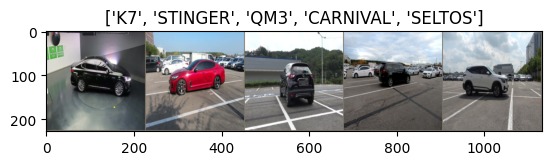

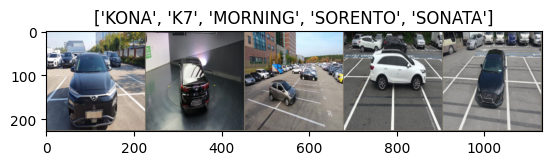

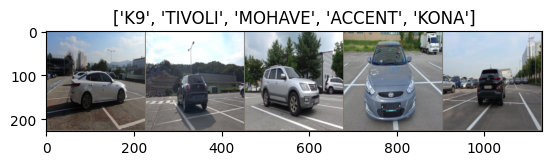

In [ ]:
import torchvision
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0)) # 텐서 numpy배열로 변환
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # 반정규화
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

num_show_img = 5

class_names={
    "0":"TIVOLI",
    "1":"PALISADE",
    "2":"PORTER2",
    "3":"I30",
    "4":"G4 REXTON",
    "5":"K3",
    "6":"K5",
    "7":"K7",
    "8":"K9",
    "9":"QM3",
    "10":"QM6",
    "11":"SM3",
    "12":"SM5",
    "13":"SM6",
    "14":"SM7",
    "15":"XM3",
    "16":"GRANDEUR",
    "17":"NIRO",
    "18":"DAMAS",
    "19":"RAY",
    "20":"REXTON SPORT",
    "21":"MAXCRUZ",
    "22":"MORNING",
    "23":"MOHAVE",
    "24":"VENUE",
    "25":"VELOSTER",
    "26":"BONGO3",
    "27":"SELTOS",
    "28":"STAREX",
    "29":"STONIC",
    "30":"STINGER",
    "31":"SPORTAGE",
    "32":"SANTAFE",
    "33":"SONATA",
    "34":"SORENTO",
    "35":"SOUL",
    "36":"AVANTE",
    "37":"IONIQ",
    "38":"ACCENT",
    "39":"CARNIVAL",
    "40":"KONA",
    "41":"KORANDO",
    "42":"KORANDO TURISMO",
    "43":"KORANDO C",
    "44":"TUCSON",
    "45":"CLIO"
}

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)


        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects, num_cnt = 0.0, 0, 0


            for inputs, labels in dataloaders[phase]: # 배치 단위
                inputs = inputs.to(device)
                labels = labels.to(device)


                optimizer.zero_grad()



                with torch.set_grad_enabled(phase == 'train'): # 학습에서만 기울기 계산
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step() # 가중치 업데이트


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) ##
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))


            if phase == 'valid' and epoch_acc > best_acc: # 모델 정확도 업데이트
                best_idx = epoch+1
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

        time_elapsed = time.time() - since
        print('{:.0f} epochs completed in {:.0f}m {:.0f}s'.format(epoch+1, time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # best model 업데이트
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss() # 엔트로피

optimizer_ft = optim.SGD(model.parameters(),
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.55 Acc: 57.5
valid Loss: 0.59 Acc: 82.0
==> best model saved - 0 / 82.0
0 epoch complete in 65m 26s
Epoch 1/9
----------
train Loss: 0.24 Acc: 92.7
valid Loss: 0.34 Acc: 89.5
==> best model saved - 1 / 89.5
1 epoch complete in 130m 18s
Epoch 2/9
----------
train Loss: 0.09 Acc: 97.4
valid Loss: 0.25 Acc: 92.0
==> best model saved - 2 / 92.0
2 epoch complete in 195m 16s
Epoch 3/9
----------
train Loss: 0.05 Acc: 98.7
valid Loss: 0.17 Acc: 94.8
==> best model saved - 3 / 94.8
3 epoch complete in 259m 55s
Epoch 4/9
----------
train Loss: 0.03 Acc: 99.1
valid Loss: 0.18 Acc: 94.2
4 epoch complete in 324m 44s
Epoch 5/9
----------


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] =8

model = EfficientNet.from_pretrained("efficientnet-b0")
model.load_state_dict(torch.load("C:/final_project/efficientnet/president_model_20230911_128batch_10epoch.pt"))

def test_and_visualize_model(model, phase = 'test', num_images=4):

    was_training = model.training
    model.eval()
    fig = plt.figure()

    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
            #     ax.imshow(inputs.cpu().data[j].permute(1,2,0))
            # if i == 0 : break
                image = inputs.cpu().data[j]
                image = image.permute(1, 2, 0)
                image = (image + 1)/2   # scale image to [0-1] from [-1,+1]
                ax.imshow(image)


    model.train(mode=was_training);  # 다시 train모드로

    ## TEST!
#model = torch.load("C:/final_project/efficientnet/EfficientNet-PyTorch/president_model_20230906_30epoch.pt")

test_and_visualize_model(model, phase = 'test')

Loaded pretrained weights for efficientnet-b0


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

<Figure size 640x480 with 0 Axes>